In [4]:
#!pip install -q transformers accelerate bitsandbytes datasets
#!pip install evaluate
from datasets import load_dataset, Dataset
# for annotation model
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
# for training transformer
from transformers import AutoConfig, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import evaluate
import torch
import pandas as pd, os, numpy as np
from tqdm.auto import tqdm


In [5]:
# Load Yelp dataset and sample 1500 reviews
raw_ds = load_dataset("Yelp/yelp_review_full")
sample_ds = raw_ds["train"].shuffle(seed=42).select(range(1500))

# We'll pretend we don't know star labels just use 'text'
df = pd.DataFrame(sample_ds)[["text"]]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

yelp_review_full/train-00000-of-00001.pa(…):   0%|          | 0.00/299M [00:00<?, ?B/s]

yelp_review_full/test-00000-of-00001.par(…):   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [6]:
from huggingface_hub import notebook_login

notebook_login()

In [8]:
# Load LLM (Gemma 2B IT)
llm_name = "google/gemma-2b-it"

tokenizer_llm = AutoTokenizer.from_pretrained(llm_name)
model_llm = AutoModelForCausalLM.from_pretrained(
    llm_name,
    device_map="auto",
    torch_dtype=torch.float16
)

tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [9]:
generator = pipeline(
    "text-generation",
    model=model_llm,
    tokenizer=tokenizer_llm,
    max_new_tokens=120,
    do_sample=False,
    temperature=0.0,
    return_full_text=False
)

Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [10]:
# CoT prompt builder
def build_cot_prompt(review: str) -> str:
    return f"""
You are an expert system for hotel review sentiment analysis.

Task: Decide whether the overall sentiment of the review is POSITIVE or NEGATIVE.

Instructions:
1. Briefly explain what parts of the review express satisfaction or dissatisfaction.
2. Then, on a new line, output the final label in the format:
   LABEL: POSITIVE
   or
   LABEL: NEGATIVE

Review:
\"\"\"{review}\"\"\"

Now think step by step, then give the final label.
"""

def build_simple_prompt(review: str) -> str:
    return f"""
You are a sentiment classifier.

Classify the overall sentiment of the following hotel review as POSITIVE or NEGATIVE.

Review:
\"\"\"{review}\"\"\"

Answer with exactly one word: POSITIVE or NEGATIVE.
"""

def extract_label_from_llm_output(gen_text: str):
    text = gen_text.upper()

    # Prefer explicit "FINAL LABEL" or "LABEL" lines if present
    if "FINAL LABEL:" in text:
        if "FINAL LABEL: POSITIVE" in text:
            return "POSITIVE"
        if "FINAL LABEL: NEGATIVE" in text:
            return "NEGATIVE"

    if "LABEL:" in text:
        # handle variants like "LABEL: POSITIVE" or "Label: negative"
        if "LABEL: POSITIVE" in text and "LABEL: NEGATIVE" not in text:
            return "POSITIVE"
        if "LABEL: NEGATIVE" in text and "LABEL: POSITIVE" not in text:
            return "NEGATIVE"

    # Fallback: global presence of POSITIVE / NEGATIVE
    if "POSITIVE" in text and "NEGATIVE" not in text:
        return "POSITIVE"
    if "NEGATIVE" in text and "POSITIVE" not in text:
        return "NEGATIVE"

    # Couldn't confidently parse
    return None

In [11]:
test = generator(
    build_cot_prompt(df['text'][0]),
    pad_token_id=tokenizer_llm.eos_token_id
)
print(test)

[{'generated_text': 'Sure, here\'s the breakdown:\n\n**Part of the review that expresses satisfaction:**\n\n* "The bowls are so so absolutely divine."\n\n**Part of the review that expresses dissatisfaction:**\n\n* "I\'ve been to industrial parks where I pretend to be a tech worker standing in line, strip mall parking lots, and of course the farmer\'s market."\n* "The owner is super friendly and he makes each bowl by hand with an incredible amount of pride."\n\n**Final label: POSITIVE**'}]


In [12]:
sent = extract_label_from_llm_output(test[0].get('generated_text'))
print(sent)

POSITIVE


In [13]:
fast_gen = pipeline(
    "text-generation",
    model=model_llm,
    tokenizer=tokenizer_llm,
    max_new_tokens=10,
    do_sample=False,
    temperature=0.0,
    return_full_text=False
)

Device set to use cuda:0


In [14]:
test = fast_gen(
    build_simple_prompt(df['text'][0]),
    pad_token_id=tokenizer_llm.eos_token_id
)
print(test)

[{'generated_text': 'POSITIVE.\n\nThe review is positive, expressing enjoyment'}]


In [15]:
# Generate labels in small batches
# Single Shot Prompt
labels = []
reasonings = []

batch_size = 32
for i in tqdm(range(0, len(df), batch_size)):
    batch_reviews = df["text"].iloc[i:i+batch_size].tolist()
    prompts = [build_simple_prompt(r) for r in batch_reviews]

    outputs = fast_gen(
        prompts,
        pad_token_id=tokenizer_llm.eos_token_id
    )

    for out in outputs:
        full_text = out[0]["generated_text"]
        label = extract_label_from_llm_output(full_text)
        labels.append(label)
        reasonings.append(full_text)
        print(label)

df["llm_label"] = labels
df["llm_raw_output"] = reasonings

  0%|          | 0/47 [00:00<?, ?it/s]

POSITIVE
POSITIVE
POSITIVE
NEGATIVE
POSITIVE
NEGATIVE
NEGATIVE
POSITIVE
NEGATIVE
POSITIVE
NEGATIVE
POSITIVE
POSITIVE
POSITIVE
NEGATIVE
POSITIVE
POSITIVE
POSITIVE
POSITIVE
POSITIVE
NEGATIVE
POSITIVE
NEGATIVE
NEGATIVE
NEGATIVE
NEGATIVE
NEGATIVE
POSITIVE
POSITIVE
POSITIVE
POSITIVE
POSITIVE
POSITIVE
POSITIVE
NEGATIVE
POSITIVE
POSITIVE
NEGATIVE
POSITIVE
POSITIVE
POSITIVE
POSITIVE
NEGATIVE
NEGATIVE
POSITIVE
NEGATIVE
NEGATIVE
POSITIVE
NEGATIVE
POSITIVE
NEGATIVE
NEGATIVE
POSITIVE
POSITIVE
POSITIVE
POSITIVE
POSITIVE
POSITIVE
POSITIVE
POSITIVE
POSITIVE
NEGATIVE
NEGATIVE
POSITIVE
POSITIVE
POSITIVE
NEGATIVE
NEGATIVE
NEGATIVE
NEGATIVE
POSITIVE
POSITIVE
NEGATIVE
POSITIVE
POSITIVE
POSITIVE
POSITIVE
NEGATIVE
POSITIVE
POSITIVE
NEGATIVE
POSITIVE
NEGATIVE
POSITIVE
NEGATIVE
POSITIVE
POSITIVE
POSITIVE
POSITIVE
POSITIVE
POSITIVE
POSITIVE
POSITIVE
POSITIVE
NEGATIVE
NEGATIVE
POSITIVE
NEGATIVE
POSITIVE
POSITIVE
POSITIVE
POSITIVE
NEGATIVE
POSITIVE
POSITIVE
POSITIVE
POSITIVE
POSITIVE
NEGATIVE
NEGATIVE
POSITIVE
P

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


POSITIVE
POSITIVE
POSITIVE
POSITIVE
NEGATIVE
POSITIVE
POSITIVE
POSITIVE
NEGATIVE
POSITIVE
POSITIVE
NEGATIVE
POSITIVE
POSITIVE
NEGATIVE
POSITIVE
POSITIVE
NEGATIVE
NEGATIVE
POSITIVE
POSITIVE
NEGATIVE
POSITIVE
POSITIVE
NEGATIVE
POSITIVE
NEGATIVE
None
NEGATIVE
POSITIVE
POSITIVE
NEGATIVE
POSITIVE
POSITIVE
NEGATIVE
POSITIVE
POSITIVE
POSITIVE
POSITIVE
NEGATIVE
NEGATIVE
NEGATIVE
POSITIVE
POSITIVE
POSITIVE
POSITIVE
POSITIVE
NEGATIVE
POSITIVE
NEGATIVE
NEGATIVE
POSITIVE
NEGATIVE
POSITIVE
NEGATIVE
POSITIVE
POSITIVE
POSITIVE
POSITIVE
NEGATIVE
POSITIVE
POSITIVE
POSITIVE
POSITIVE
POSITIVE
NEGATIVE
None
NEGATIVE
POSITIVE
POSITIVE
POSITIVE
NEGATIVE
POSITIVE
POSITIVE
NEGATIVE
NEGATIVE
POSITIVE
POSITIVE
NEGATIVE
POSITIVE
POSITIVE
NEGATIVE
POSITIVE
POSITIVE
NEGATIVE
NEGATIVE
POSITIVE
NEGATIVE
NEGATIVE
NEGATIVE
NEGATIVE
NEGATIVE
POSITIVE
POSITIVE
POSITIVE
POSITIVE
NEGATIVE
NEGATIVE
POSITIVE
NEGATIVE
POSITIVE
POSITIVE
POSITIVE
NEGATIVE
NEGATIVE
NEGATIVE
NEGATIVE
NEGATIVE
POSITIVE
NEGATIVE
NEGATIVE
NEGATIVE


In [16]:
df['llm_label'].value_counts(normalize=True)

,proportion
llm_label,
POSITIVE,0.607646
NEGATIVE,0.392354


In [17]:
df['llm_raw_output'].value_counts(normalize=True)

,proportion
llm_raw_output,
"POSITIVE.\n\nThe review is positive, as it",0.175333
"POSITIVE.\n\nThe review expresses a positive sentiment,",0.113333
POSITIVE.\n\nThe review is positive as it expresses,0.048000
"POSITIVE.\n\nThe review has a positive sentiment,",0.047333
The sentiment of the review is NEGATIVE.,0.044000
...,...
POSITIVE.\n\nThe review expresses positive sentiments towards Custom,0.000667
NEGATIVE.\n\nThe review expresses dissatisfaction with the slow,0.000667
"NEGATIVE.\n\nThe review contains negative language, such",0.000667


In [18]:
print(f'Unlabled Records: {df['llm_label'].isna().sum()}')
# drop those records
df = df.dropna(axis=0, how='any')
print(f'Final df shape: {df.shape}')
df.head()


Unlabled Records: 9
Final df shape: (1491, 3)


,text,llm_label,llm_raw_output
0,I stalk this truck. I've been to industrial p...,POSITIVE,"POSITIVE.\n\nThe review is positive, expressin..."
1,"who really knows if this is good pho or not, i...",POSITIVE,POSITIVE.\n\nThe review expresses positive sen...
2,I LOVE Bloom Salon... all of their stylist are...,POSITIVE,POSITIVE.\n\nThe review expresses positive sen...
3,"We were excited to eat here, it is difficult t...",NEGATIVE,The review is NEGATIVE as it expresses a sense of
4,"So this is a place, with food. That much canno...",POSITIVE,"POSITIVE.\n\nThe review is positive, as it"


In [19]:
# Generate labels in small batches
# Chain of Thought Prompt
'''labels = []
reasonings = []

batch_size = 32
for i in tqdm(range(0, len(df), batch_size)):
    batch_reviews = df["text"].iloc[i:i+batch_size].tolist()
    prompts = [build_cot_prompt(r) for r in batch_reviews]

    outputs = generator(
        prompts,
        pad_token_id=tokenizer_llm.eos_token_id
    )

    for out in outputs:
        full_text = out[0]["generated_text"]
        label = extract_label_from_llm_output(full_text)
        labels.append(label)
        reasonings.append(full_text)
        print(label)

df["llm_label"] = labels
df["llm_raw_output"] = reasonings'''

'labels = []\nreasonings = []\n\nbatch_size = 32\nfor i in tqdm(range(0, len(df), batch_size)):\n    batch_reviews = df["text"].iloc[i:i+batch_size].tolist()\n    prompts = [build_cot_prompt(r) for r in batch_reviews]\n\n    outputs = generator(\n        prompts,\n        pad_token_id=tokenizer_llm.eos_token_id\n    )\n\n    for out in outputs:\n        full_text = out[0]["generated_text"]\n        label = extract_label_from_llm_output(full_text)\n        labels.append(label)\n        reasonings.append(full_text)\n        print(label)\n\ndf["llm_label"] = labels\ndf["llm_raw_output"] = reasonings'

In [20]:

df["llm_label"] = df["llm_label"].map({"POSITIVE": 1, "NEGATIVE": 0})
df.to_csv("/content/annotated_reviews.csv", index=False)
# convert df to dataset
ds = Dataset.from_pandas(df)
# split dataset into train/test
ds = ds.train_test_split(test_size=0.15, seed=42)
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'llm_label', 'llm_raw_output', '__index_level_0__'],
        num_rows: 1267
    })
    test: Dataset({
        features: ['text', 'llm_label', 'llm_raw_output', '__index_level_0__'],
        num_rows: 224
    })
})

In [21]:
from collections import Counter

Counter(ds['train']["llm_label"])

Counter({0: 491, 1: 776})

In [22]:
from pathlib import Path

# Choose a compact, strong baseline
model_checkpoint = "microsoft/deberta-v3-small"

# Define labels
LABELS = ["NEGATIVE", "POSITIVE"]
id2label = {i: lbl for i, lbl in enumerate(LABELS)}
label2id = {lbl: i for i, lbl in enumerate(LABELS)}

# Load and modify config
config = AutoConfig.from_pretrained(model_checkpoint)
config.id2label = id2label
config.label2id = label2id
config.num_labels = 2
config

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

DebertaV2Config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "layer_norm_eps": 1e-07,
  "legacy": true,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att_key": true,
  "transformers_version": "4.57.1",
  "type_vocab_size": 0,
  "vocab_size": 128100
}

In [23]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=256)

tokenized = ds.map(tokenize, batched=True)
# Trainer expects column "labels"
tokenized = tokenized.rename_column("llm_label", "labels")

# Keep only necessary columns
cols_to_keep = ["input_ids", "attention_mask", "labels"]
tokenized = tokenized.remove_columns([c for c in tokenized["train"].column_names if c not in cols_to_keep])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/1267 [00:00<?, ? examples/s]

Map:   0%|          | 0/224 [00:00<?, ? examples/s]

In [24]:
from collections import Counter

Counter(tokenized['test']["labels"])

Counter({1: 130, 0: 94})

In [25]:
model_checkpoint = "microsoft/deberta-v3-small"

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, config=config, ignore_mismatched_sizes=True
)

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount("/content/drive")
    base_folder = Path("/content/drive/MyDrive/data")
else:
    base_folder = Path("./")

os.environ["WANDB_DISABLED"] = "true"  # keep W&B off

model_folder = base_folder / "models/sentiment/distilbert"
model_folder.mkdir(exist_ok=True, parents=True)

Mounted at /content/drive


In [27]:
acc_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(logits_and_labels):
    """
    Compute sequence-level classification metrics (e.g., sentiment analysis).

    Args:
    - logits_and_labels (tuple): A tuple containing model logits and true labels.

    Returns:
    - dict: A dictionary containing accuracy, precision, recall, and f1-score (macro-averaged).
    """

    # Separate logits and true labels
    logits, true_labels = logits_and_labels

    # Obtain predicted class indices by selecting the highest logit for each example
    predicted_indices = np.argmax(logits, axis=-1)

    # Compute standard classification metrics
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support

    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels,
        predicted_indices,
        average="macro",  # macro averages across classes for balanced comparison
        zero_division=0
    )

    accuracy = accuracy_score(true_labels, predicted_indices)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [28]:
# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=3,  # Total number of training epochs
    warmup_ratio=0.01,
    # Number of samples per training batch for each device
    per_device_train_batch_size=8,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=8,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=5e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer
    gradient_accumulation_steps = 4,
    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy ='steps',  # Evaluate model at specified step intervals
    eval_steps=40,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=2000,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="accuracy",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher
    bf16 = True,
    max_grad_norm = 1.0,
    gradient_checkpointing = False,
    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    run_name= 'ner_exp1',  # Experiment name for Weights & Biases
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [29]:
from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=2))
trainer.accelerator.free_memory()
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
40,0.382200,0.310817,0.870536,0.866445,0.873732,0.868627
80,0.246100,0.281998,0.870536,0.882808,0.854583,0.862858
120,0.143600,0.313909,0.892857,0.895517,0.884124,0.888557


TrainOutput(global_step=120, training_loss=0.3089670976003011, metrics={'train_runtime': 60.1126, 'train_samples_per_second': 63.231, 'train_steps_per_second': 1.996, 'total_flos': 251763258829824.0, 'train_loss': 0.3089670976003011, 'epoch': 3.0})

ROC-AUC: 0.8841243862520458
              precision    recall  f1-score   support

    NEGATIVE      0.907     0.830     0.867        94
    POSITIVE      0.884     0.938     0.910       130

    accuracy                          0.893       224
   macro avg      0.896     0.884     0.889       224
weighted avg      0.894     0.893     0.892       224



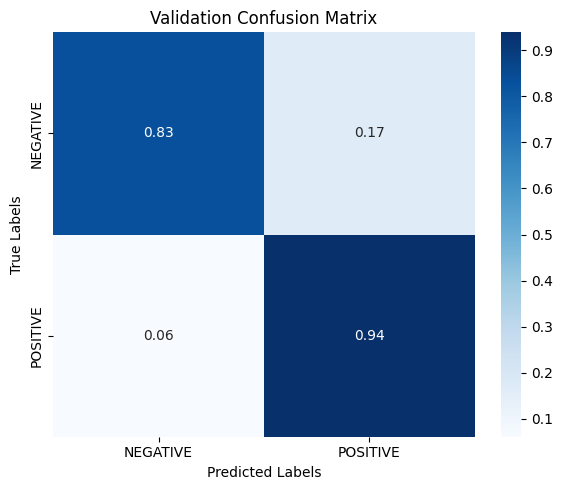

In [30]:
#trainer.evaluate(tokenized["test"])
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

valid_output = trainer.predict(tokenized["test"])
preds = np.argmax(valid_output.predictions, axis=-1)
y_true = valid_output.label_ids

cm = confusion_matrix(y_true, preds, normalize='true')
print("ROC-AUC:", roc_auc_score(y_true, preds))
print(classification_report(y_true, preds, target_names=LABELS, digits=3))
plt.figure(figsize=(6,5))
ax = sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                 xticklabels=LABELS, yticklabels=LABELS)
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Validation Confusion Matrix")
plt.tight_layout()
plt.show()

In [32]:
ds['test']['text'][0]

"I have been enjoying the massages with hot rocks and great service for over a year now and yes, I'm a fan. My last visit I tried a gel manicure and now I'm a convert. The manicure I received 9 days ago, still looks pristine, shiny. The application process is more involved and takes a little longer that the standard manicure but for only 10 dollars more - it is so worth it."

In [33]:
tokenizer.decode(tokenized['test'][0].get('input_ids'))

"[CLS] I have been enjoying the massages with hot rocks and great service for over a year now and yes, I'm a fan. My last visit I tried a gel manicure and now I'm a convert. The manicure I received 9 days ago, still looks pristine, shiny. The application process is more involved and takes a little longer that the standard manicure but for only 10 dollars more - it is so worth it.[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PA

In [34]:
print(f'predicted: {preds[0]}\nactual: {y_true[0]}')

predicted: 1
actual: 1


# Training for another epoch

In [36]:
training_args.num_train_epochs = 4

In [37]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=2))
trainer.accelerator.free_memory()
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
40,0.196600,0.592514,0.834821,0.870600,0.807610,0.818592
80,0.075500,0.546409,0.875000,0.896930,0.855483,0.866017
120,0.044000,0.534883,0.875000,0.889403,0.858429,0.867287
160,0.006400,0.537422,0.888393,0.899389,0.874386,0.882291


TrainOutput(global_step=160, training_loss=0.09150495994836091, metrics={'train_runtime': 53.6744, 'train_samples_per_second': 94.421, 'train_steps_per_second': 2.981, 'total_flos': 335684345106432.0, 'train_loss': 0.09150495994836091, 'epoch': 4.0})

ROC-AUC: 0.8743862520458265
              precision    recall  f1-score   support

    NEGATIVE      0.937     0.787     0.855        94
    POSITIVE      0.862     0.962     0.909       130

    accuracy                          0.888       224
   macro avg      0.899     0.874     0.882       224
weighted avg      0.893     0.888     0.887       224



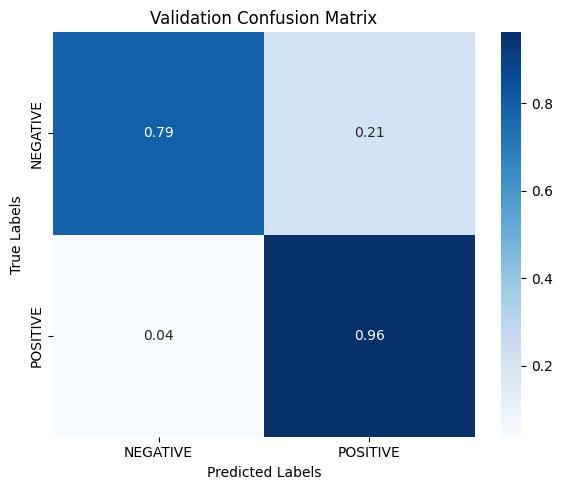

In [38]:
valid_output = trainer.predict(tokenized["test"])
preds = np.argmax(valid_output.predictions, axis=-1)
y_true = valid_output.label_ids

cm = confusion_matrix(y_true, preds, normalize='true')
print("ROC-AUC:", roc_auc_score(y_true, preds))
print(classification_report(y_true, preds, target_names=LABELS, digits=3))
plt.figure(figsize=(6,5))
ax = sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                 xticklabels=LABELS, yticklabels=LABELS)
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Validation Confusion Matrix")
plt.tight_layout()
plt.show()

# Smaller Batch Size + lr

In [48]:
training_args.per_device_train_batch_size = 16
training_args.learning_rate = 1e-5
training_args.num_train_epochs = 3

In [49]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=2))
trainer.accelerator.free_memory()
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
40,0.001900,0.686302,0.910714,0.912433,0.903928,0.907461


TrainOutput(global_step=60, training_loss=0.0013828129352380831, metrics={'train_runtime': 37.7998, 'train_samples_per_second': 100.556, 'train_steps_per_second': 1.587, 'total_flos': 251763258829824.0, 'train_loss': 0.0013828129352380831, 'epoch': 3.0})

Accuracy: 0.8973214285714286
ROC-AUC: 0.885024549918167
              precision    recall  f1-score   support

    NEGATIVE      0.938     0.809     0.869        94
    POSITIVE      0.874     0.962     0.916       130

    accuracy                          0.897       224
   macro avg      0.906     0.885     0.892       224
weighted avg      0.901     0.897     0.896       224



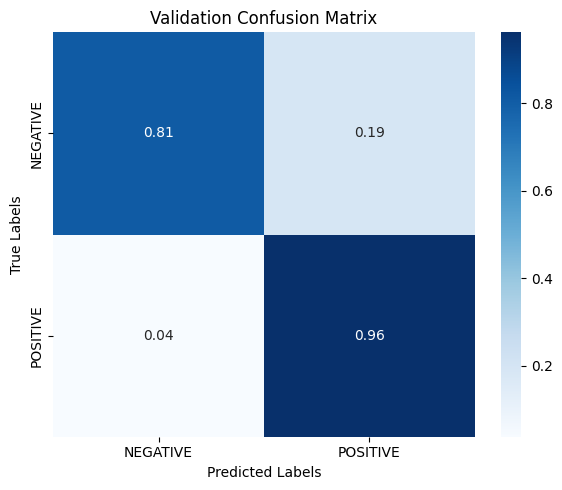

In [50]:
valid_output = trainer.predict(tokenized["test"])
preds = np.argmax(valid_output.predictions, axis=-1)
y_true = valid_output.label_ids

cm = confusion_matrix(y_true, preds, normalize='true')
print("Accuracy:", accuracy_score(y_true, preds))
print("ROC-AUC:", roc_auc_score(y_true, preds))
print(classification_report(y_true, preds, target_names=LABELS, digits=3))
plt.figure(figsize=(6,5))
ax = sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                 xticklabels=LABELS, yticklabels=LABELS)
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Validation Confusion Matrix")
plt.tight_layout()
plt.show()

## Out of Box Model

In [43]:
# Replace this with your own checkpoint
model_checkpoint = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"
text_classifier = pipeline(
    model=model_checkpoint
)
text_classifier.tokenizer.max_length = 256

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cuda:0


In [44]:
text_classifier(tokenizer.decode(tokenized['test'][0].get('input_ids')))

[{'label': 'POSITIVE', 'score': 0.9853674173355103}]

In [46]:
from transformers.pipelines.pt_utils import KeyDataset
preds = []
for out in text_classifier(KeyDataset(ds['test'], "text"), batch_size=8, truncation="only_first"):
    preds.append(out)

== Baseline (DistilBERT SST-2) ==
Accuracy: 0.8616071428571429
ROC-AUC: 0.8719312602291326

Classification report:
               precision    recall  f1-score   support

    NEGATIVE       0.78      0.94      0.85        94
    POSITIVE       0.95      0.81      0.87       130

    accuracy                           0.86       224
   macro avg       0.86      0.87      0.86       224
weighted avg       0.88      0.86      0.86       224



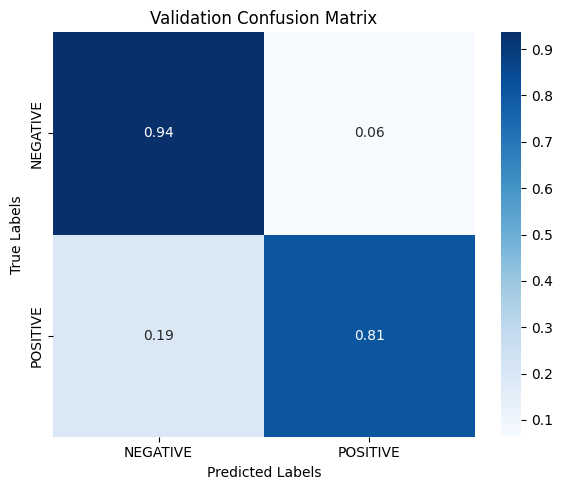

In [47]:
def map_hf_preds_binary(preds):
    # Handle both 'POSITIVE/NEGATIVE' and 'LABEL_0/LABEL_1' styles
    def to_int(label):
        lbl = str(label).upper()
        if lbl in ("POSITIVE", "LABEL_1", "1"):
            return 1
        elif lbl in ("NEGATIVE", "LABEL_0", "0"):
            return 0
        else:
            raise ValueError(f"Unexpected label: {label}")

    y_pred = np.array([to_int(p['label']) for p in preds], dtype=int)
    # Probability of the positive class for ROC-AUC: if predicted POS, use score; else use 1-score
    y_score = np.array([p['score'] if to_int(p['label'])==1 else (1 - p['score']) for p in preds], dtype=float)
    return y_pred, y_score

y_pred_base, y_score_base = map_hf_preds_binary(preds)

# y_true: array-like of shape (n_samples,) with 0/1 labels
print("== Baseline (DistilBERT SST-2) ==")
print("Accuracy:", accuracy_score(y_true, y_pred_base))
print("ROC-AUC:", roc_auc_score(y_true, y_pred_base))
print("\nClassification report:\n", classification_report(y_true, y_pred_base, target_names=["NEGATIVE","POSITIVE"]))
cm = confusion_matrix(y_true, y_pred_base, normalize='true')
plt.figure(figsize=(6,5))
ax = sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                 xticklabels=LABELS, yticklabels=LABELS)
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Validation Confusion Matrix")
plt.tight_layout()
plt.show()